### TalTech Walk

#### consider only the walking trials 

- compute skeletal loading metrics for right and left limb (total and each axis)
- compute the frequency response for right and left limb (total)
- compute the total power

In [14]:
import os
import glob
import matplotlib.pyplot as plt
import taltech_helpers as h # contains the computations
import numpy as np
import pandas as pd
import json
from scipy.signal import correlate
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
import math

In [15]:
# read in all the clean data
base = "../../data/clean/"
data = h.read_in_clean_taltech_data(base)

reading taltech data files from ../../data/clean/
['baseline', 'flight']
['exp1', 'exp2']
['barefoot', 'shoes']
['barefoot', 'shoes']
['exp1', 'exp2']
['barefoot', 'shoes']
['barefoot', 'shoes']


In [16]:
exp = 1

In [17]:
# test loading computation functions
def vector_magnitude(vectors):
    n = len(vectors[0])
    assert all(len(v) == n for v in vectors), "Vectors have different lengths"
    vm = np.sqrt(sum(v ** 2 for v in vectors))
    return vm

def build_filter(frequency, sample_rate, filter_type, filter_order):
    #nyq = 0.5 * sample_rate
    if filter_type == "band":
        #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1], btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)

    return b, a


def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)
    

def compute_fft_mag(data):
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(data)))))
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) / (fftpoints/2) # check this
    return mag.tolist()

def fft_graph_values(fft_mags, sample_rate):
    T = 1/sample_rate
    N_r =len(fft_mags)//2
    x = np.linspace(0.0, 1.0/(2.0*T), len(fft_mags)//2).tolist()
    y = fft_mags[:N_r]
    
    return [x,y]
# computes the actual loading value
def compute_loading_intensity(fft_magnitudes, sampling_frequency, high_cut_off):
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(fft_magnitudes)))))
    LI = 0
    fs = sampling_frequency
    fc = high_cut_off
    kc = int((fftpoints/fs)* fc) + 1

    magnitudes = fft_magnitudes

    f = []
    for i in range(0, int(fftpoints/2)+1):
        f.append((fs*i)/fftpoints)

    for k in range(0, kc):
        LI = LI + (magnitudes[k] * f[k])

    return LI
def compute_skeletal_loading(accel_x, accel_y, accel_z, sampling_rate, lc_off, hc_off, filter_order, filter_type):
    # build the filter
    b,a = build_filter((lc_off, hc_off), sampling_rate, filter_type, filter_order)
    
    accel_x = accel_x.to_numpy()  
    accel_y = accel_y.to_numpy()  
    accel_z = accel_z.to_numpy()  
    
    # compute the magnitude vector
    a_mag = vector_magnitude([accel_x, accel_y, accel_z])
    # filter the magnitude
    filtered_mag = filter_signal(b,a, a_mag, "filtfilt")
    # compute the frequency response
    fft_mag = compute_fft_mag(filtered_mag)
    #fft_graph = compute_frequency_response(df, sampling_rate, b,a )
    # compute the loading intensity
    li_result = compute_loading_intensity(fft_mag, sampling_rate, hc_off)

def compute_skeletal_loading_metrics(df, sampling_rate, lc_off, hc_off, filter_order, filter_type):
    # extract the axes
    a_x = df["X"]
    a_y = df["Y"]
    a_z = df["Z"]

    # total loading
    total_li = compute_skeletal_loading(a_x, a_y, a_z, 
                                        sampling_rate, 
                                        lc_off, 
                                        hc_off, 
                                        filter_order, filter_type)




169.6415129673259


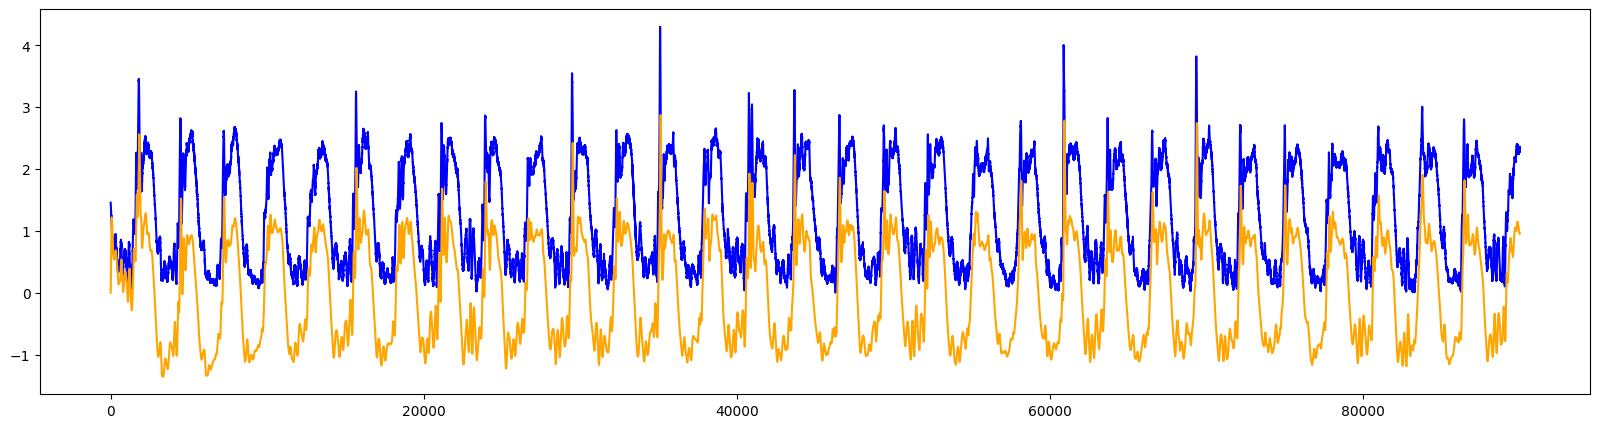

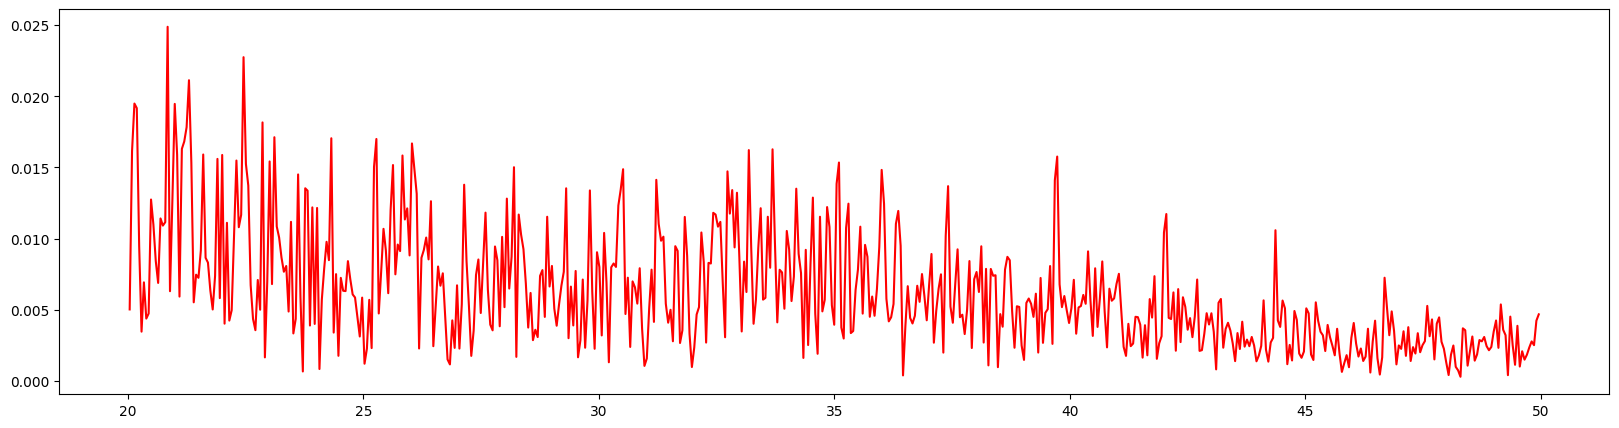

In [63]:
# env = "baseline"
exp = 1
d="bj26"

if("s" in d):
    fw = "shoes"
else:
    fw = "barefoot"
df = data[env][f"exp{str(exp)}"][fw][d]

a_x = df["X"]
a_y = df["Y"]
a_z = df["Z"]

accel_x = a_x.to_numpy()  
accel_y = a_y.to_numpy()  
accel_z = a_z.to_numpy()  
   
# test magnitude vector
 # compute the magnitude vector
a_mag = vector_magnitude([accel_x, accel_y, accel_z])

# test filter
sampling_rate = 6600
lc_off = 0.5
hc_off = 50
filter_order = 2
filter_type = "band"
freq_min = 20
freq_max = 50

b,a = build_filter((lc_off, hc_off), sampling_rate, filter_type, filter_order)
filtered_mag = filter_signal(b,a, a_mag, "lfilter")

fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax.plot(a_mag, color="blue")
ax.plot(filtered_mag, color="orange")

# test fft
fft_mag = compute_fft_mag(filtered_mag)
graph = fft_graph_values(fft_mag, sampling_rate)

freqs = np.array(graph[0])  # Convert list to a NumPy array



# Create a mask for the range
mask = (freqs >= freq_min) & (freqs <= freq_max)
# Use the mask to filter frequencies and corresponding magnitudes
filtered_freqs = freqs[mask]
filtered_fft_mag  = np.array(graph[1])[mask]  

fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax.plot(filtered_freqs, filtered_fft_mag, color="red")

# test li computation
li = compute_loading_intensity(fft_mag, sampling_rate, hc_off)
print(li)